<a href="https://colab.research.google.com/github/sejin-sim/Object_detection/blob/main/Faster_R-CNN/Faster_R_CNN_Implementations_by_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)
# cpu or gpu 따라서 model 설정

cuda Tesla T4


Data Preprocessing

1) Visualize image and bounding boxes


--2021-01-27 04:59:36--  https://github.com/herbwood/pytorch_faster_r_cnn/blob/main/zebras.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/herbwood/pytorch_faster_r_cnn/raw/main/zebras.jpg [following]
--2021-01-27 04:59:37--  https://github.com/herbwood/pytorch_faster_r_cnn/raw/main/zebras.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/herbwood/pytorch_faster_r_cnn/main/zebras.jpg [following]
--2021-01-27 04:59:37--  https://raw.githubusercontent.com/herbwood/pytorch_faster_r_cnn/main/zebras.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent

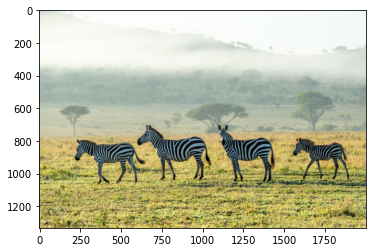

In [ ]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size

!wget https://github.com/herbwood/pytorch_faster_r_cnn/blob/main/zebras.jpg?raw=true -O zebras.jpg

img0 = cv2.imread("/content/zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) # BGR TO RGB

print(img0.shape)
plt.imshow(img0)
plt.show()

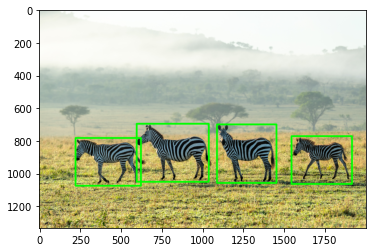

In [ ]:
# object information : a set of bounding boxes [x1, y1, x2, y2]  (바운딩 박스 지정 = Y)
# and their labels

bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 

labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

# display bounding box and labels

img0_clone = np.copy(img0) # 이미지 복사

for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), # start 좌표 (x1, y1)
                              (bbox0[i][2], bbox0[i][3]), # end 좌표 (x2, y2)
                 color=(0, 255, 0), thickness=10) # Green
plt.imshow(img0_clone)
plt.show()

2) Resize image and bounding boxes

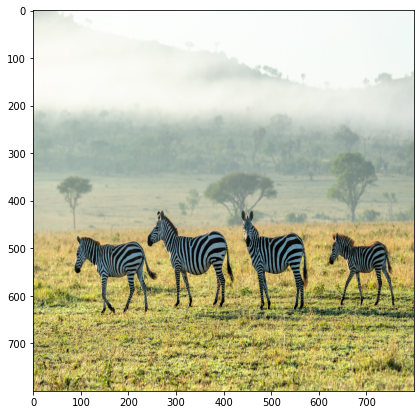

In [ ]:
# resize the input images to h=800, w=800. 사이즈 800 x 800으로

img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
# plt.grid(True, color="black")
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


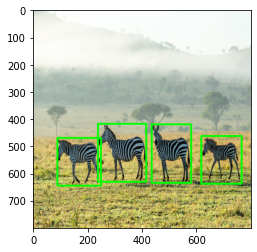

In [ ]:
# change the bounding box coordinates(좌표)
# original image size : (1333, 2000)

Wratio = 800/img0.shape[1] # width ratio = 800 / 2000
Hratio = 800/img0.shape[0] # height ratio = 800 / 1333

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio] # [0.4, 0.6, 0.4, 0.6]
bbox = []

# bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
#                   [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    # 223 x 0.4, 782 x 0.6 ~~~
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

Define Feature extractor : 피쳐 추출기 정의

1) Load pretrained VGG16


In [ ]:
# only print feature extraction part of VGG16 : VGG16의 핏쳐 추출 부분만 프린트
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)

features = list(model.features)
print(len(features))
model.features

31


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

2) Only collect required layers : 필요 계층만 수집


In [ ]:
# only collect layers with output feature map size (W, H) < 50

dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
    print(output.size()) # => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16:   # 50보다 작은건 MaxPooling
        break 
    req_features.append(feature)
    out_channels = output.size()[1]  # 최종 torch.Size([1, 512, 50, 50])
    
print(len(req_features)) # MaxPooling제외 30개
print(out_channels)

torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 25, 25])
30
512


In [ ]:
# convert this list into a Seqeuntial module : Seqeuntial module(순차 모듈)로 변환

faster_rcnn_feature_extractor = nn.Sequential(*req_features)
# 편하게 순차적으로 실행하도록 담는 container
faster_rcnn_feature_extractor # MAX Pooling 제외된걸 볼 수 잇다.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
# test the results of the input image pass through the feature extractor
# 기능 추출기를 통과하는 입력 이미지의 결과를 테스트합니다.

transform = transforms.Compose([transforms.ToTensor()])
# compose : 변환 함수들을 하나로 조합하는 함수. ToTensor:torch.Tensor로 변환시킨다.

imgTensor = transform(img).to(DEVICE)
# compose 함수를 dataloader에 넘기면 이미지 변환 작업이 간단하게 완료된다.
print(imgTensor.size())

imgTensor = imgTensor.unsqueeze(0)
# 첫번째 차원(0)에 1인 차원이 추가됩니다
print(imgTensor.size())

output_map = faster_rcnn_feature_extractor(imgTensor)
# Pass the image to the model : 이미지를 모델에 넘긴다.
print(output_map.size())

torch.Size([3, 800, 800])
torch.Size([1, 3, 800, 800])
torch.Size([1, 512, 50, 50])


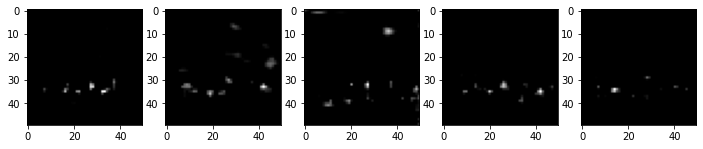

In [ ]:
# visualize the first 5 channels of the 50*50*512 feature maps
# 50 * 50 * 512 핏쳐맵의 처음 5개 채널을 시각화

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

Generate Anchors Boxes : 앵커 박스 생성

1) Generate Anchors : 앵커 생성

In [ ]:
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center : x, y 간격으로 앵커 박스 중심 생성

feature_size = 800 // 16 # 50
ctr_x = np.arange(16, (feature_size + 1) * 16, 16) # 16간격으로 16부터 815(51*16 -1)까지
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
# coordinates of the 255 center points to generate anchor boxes
# 앵커 박스 생성 위한 255개의 중심점 좌표

index = 0
ctr = np.zeros((2500, 2))  # 2500 x 2

for i in range(len(ctr_x)):     # 50번 반복
    for j in range(len(ctr_y)): # 50번 반복
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr)

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 ...
 [760. 792.]
 [776. 792.]
 [792. 792.]]


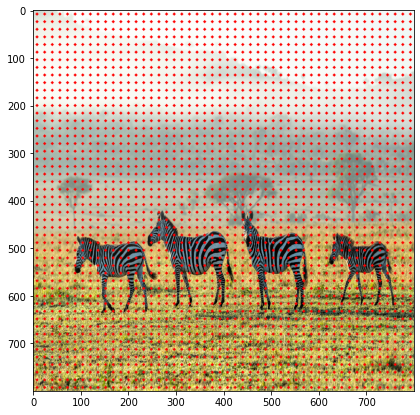

In [ ]:
# display the 2500 anchors within image : 2500개 엥커를 이미지에 그린다.

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]): # 2500
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]), 
               radius = 1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

2) Generate Anchor boxes

Anchor scale과 ratio로 box를 판단할 모양을 만들어줍니다. (anchor_template)

anchor 하나당 scale 3, ratio 3으로 총 9개입니다.


In [ ]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 x 9 = 22500 anchor boxes

# 2500 개의 앵커 각각에 대해 9 개의 앵커 상자를 생성합니다. 
# 2500 x 9 = 22500 개의 앵커 상자 

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


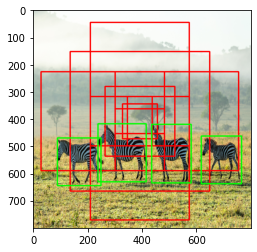

In [ ]:
# display the anchor boxes of one anchor and the ground truth boxes
# 그라운드 트루스(Ground Truth) : 이미지나 동영상에 있는 객체를 파악하기 위해 라벨링을 하는 작업

img_clone = np.copy(img)

# draw random anchor boxes : 임의 앵커박스 그린다.
for i in range(11025, 11034): # 11034 - 11025 = 9개
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes : 라벨링한 앵커박스
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

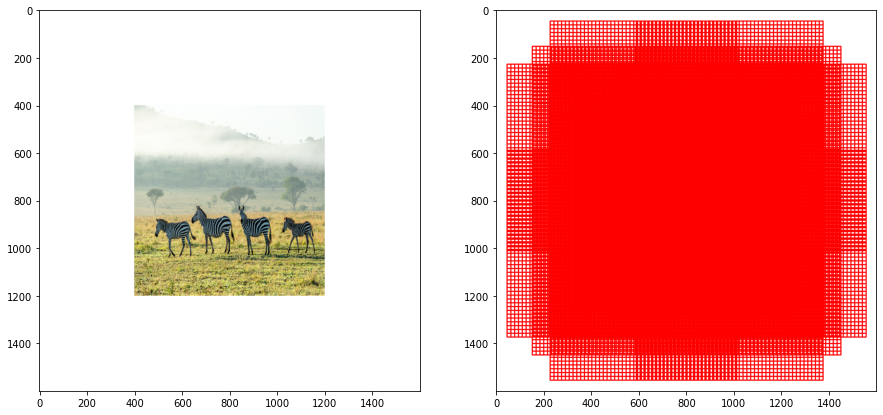

In [ ]:
# draw all anchor boxes : 모든 앵커 상자 그리기 
# add paddings(can't draw anchor boxes out of image boundary) : 패딩 추가 (이미지 경계에서 앵커 상자를 그릴 수 없음)

img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(15, 15))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

이미지 박스가 800 x 800이고, 각각의 anchor별로 template을 적용했을 때, 나오는 22500개 (50x50x9)의 anchor box들입니다.


Target Anchors

1) Only choose anchor boxes inside the image : 이미지 내 앵커 박스 만 선택

In [ ]:
# ignore the cross-boundary anchor boxes : 교차 경계 앵커 박스 무시
# valid(유효) anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
# 단지 8940 개의 앵커 박스가 22500 개 중 경계 안에 있습니다. 
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


2) Calculate IoUs

argmax_ious — Tells which ground truth object has max iou with each anchor.

max_ious — Tells the max_iou with ground truth object with each anchor.

gt_argmax_ious — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.

In [ ]:
# calculate Iou of the valid anchor boxes : 유효한 앵커 박스의 Iou를 계산합니다.

# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# 우리는 8940 개의 앵커 박스와 4 개의 Ground Truth 객체를 가지고 있기 때문에
# 출력으로 (8940, 4)를 가진 배열을 얻어야합니다. 

# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]

ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


3) Sample positive/negative anchor boxes

In [ ]:
# what anchor box has max iou with the ground truth box

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [ ]:
# what ground truth bbox is associated with each anchor box

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]
(8940,)


In [ ]:
# use IoU to assign 1 (objects) to two kind of anchors
# IoU를 사용하여 두 종류의 앵커에 1 (객체) 할당 

# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box
# a) 가장 높은 IoU를 가진 앵커가 지상 진리 값 상자와 겹칩니다. 
# b) IoU가 0.7보다 높은 앵커가 지상 진리 상자와 겹칩니다. 

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [ ]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 

# 미니배치 훈련 때마다 "RPN"을 훈련하기 위해 256개의 유효한 앵커 박스만 사용하며, 
# 이중 128개의 양성 예제, 128개의 음성 예제이다.
# 나머지 양성/음성 앵커 비활성화

n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [ ]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]

# For each valid anchor box, find the groundtruth object which has max_iou 
# 각 유효한 앵커 상자에 대해 max_iou가 있는 실측근 객체를 찾습니다.

max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [ ]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

# 라벨 =-1 및 위치 = 22500 앵커 박스 중 0을 먼저 설정합니다.
# 8940개의 유효한 앵커 박스의 위치와 라벨을 기입합니다.
# 주의: 각 교육 기간에 대해 8940개의 유효한 앵커 상자에서 
# 128개의 양성 + 128개의 음성을 무작위로 선택하며, 나머지 항목은 -1로 표시됩니다.

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

# 최종적으로 label하고, loc을 계산한 앵커들이 나오게 됩니다.

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


RPN(Region Proposal Network)

1) Define RPN

In [ ]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)
# 입력 이미지의 특징을 RPN (Region Proposal Network)에 전송하고, 
# 22500 개의 지역 제안 (ROI)을 예측합니다. 

# VGG Net 기준 conv layer의 output channel이 512이라서 in channel은 512가 되고,
# box regression은 anchor 9 * 4 (location)
# box classification은 anchor 9 * 2 (object or not)

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

2) Classification and Bounding box regression

In [ ]:
# weight 초기화를 거쳐, 추출한 feature map을 conv에 통과시키고,
# location과 class를 예측합니다.

x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)
# 각 위치별 (50, 50) regression 과 classification 예측 값이 나오게 됩니다.


torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [ ]:
# Convert RPN to predict the position and classification format of the anchor box
# 앵커 박스의 위치와 분류 형식을 예측하도록 RPN을 변환합니다. 
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, pred_anchor_locs_numpy2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [ ]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 

# calculate the RPN loss : RPN 손실 계산

print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)
torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


3) Multi-task loss

In [ ]:
# For classification we use cross-entropy loss
# 분류를 위해 우리는 교차 엔트로피 로스를 사용
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())


tensor(0.7016, device='cuda:0', grad_fn=<NllLossBackward>)
torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(16.0104, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss : rpn_cls_loss와 rpn_reg_loss 모두 결합 

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.2595, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


Proposal layer

1) Transform anchor boxes

RPN에서 구한 Proposal을 Fast R-CNN에서 학습할것만 남기는 과정입니다.


In [ ]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000
# RPN에 의해 ​​예측 된 22500 ROI를 Fast RCNN으로 전송하여 bbox + 분류를 예측합니다. 
# 먼저 NMS (Non-maximum supression)를 사용하여 22500 ROI를 2000으로

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [ ]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [ ]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [ ]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


2) Clip the anchor boxes to the image

In [ ]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500, 4) 800.0 0.0
(22500,) (22500, 4) (22500,)


3) Select top-12000 anchor boxes by objectness score : 객체 가능성 점수로 상위 12000개 앵커 박스 선택



In [ ]:
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(22500,)
(12000,) (12000, 4)


4) Non maximum suppression(select 2000 bounding boxes)

In [ ]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

# nms를 적용해 2000개의 roi만 남깁니다.

2000 (2000, 4)


Proposal Target layer

1) Calculate IoUs

여기서부턴 RPN에서 ground truth를 만드는 과정과 같습니다.

단지 Fast RCNN을 위한 ground truth를 만드는 것이 차이 (실제 클래스, 실제 bounding box)


In [ ]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

# 위에서 구한 2000개의 roi와 bbox를 비교해 iou를 계산해줍니다.


(2000, 4)


In [ ]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[3 3 3 ... 0 0 0]
[0.06386232 0.17847884 0.06535928 ... 0.         0.03378766 0.1712278 ]
[1 1 1 ... 1 1 1]


2) Select foreground(positive) samples

In [ ]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

30
[ 189  297   78  245 1883  605  190 1383   74 1385  247  706  298 1187
  347 1273 1827 1315 1380  301 1379  296  348 1272  246  351  883  115
  529 1882]


3) Select background(negative) samples

In [ ]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

98
[ 521 1870 1293 1651 1470 1110 1286 1389 1340  621  466 1193  606  952
  800  613 1339  574  625 1266 1791 1919  537 1062 1472 1471  432 1907
   17 1699 1313  300 1876 1497 1312  738  186 1852  448  492 1395  589
 1717  435 1988  374 1371 1910 1347 1734 1028 1940  553  567  522  524
 1531  274 1370 1623 1440  689  557  577 1775  785  311  445  143 1995
 1402 1937 1548 1562 1144   40  901 1835 1733 1637  429 1215  866  735
  325 1314 1368 1691  846 1355  757  211  745 1996 1790 1941 1537  447]


4) Visualization

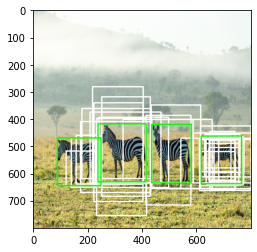

In [ ]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

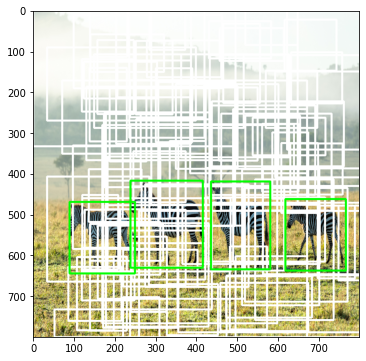

In [ ]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()


5) Gather positive/negative samples

In [ ]:

# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [ ]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [ ]:

width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height

In [ ]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


RoI pooling

1) Concatenate labels with bbox coordinates

In [ ]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [ ]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


2) RoI pooling

In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


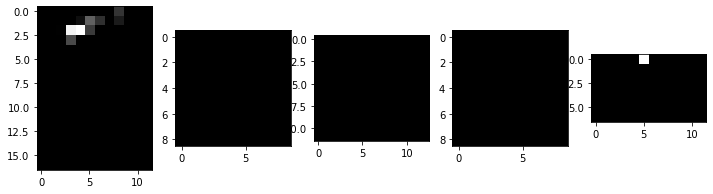

In [ ]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [ ]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


Fast R-CNN

1) Classifier and Bounding box regressor

In [ ]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE)
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE) # 1 class, 1 background
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8]) torch.Size([128, 2])
torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2) Classification loss

In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])



3) Regression loss

In [ ]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])


In [ ]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([30, 4]) torch.Size([30, 4])
tensor(6.1083, dtype=torch.float64, grad_fn=<SumBackward0>)
